## Import

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from datetime import datetime
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode()
import pylab as pl


## Load The Data

In [4]:
df = pd.read_csv("data/yellow_tripdata_2017-06.csv", infer_datetime_format= True)
df_taxi_zone_lookup = pd.read_csv("data/taxi+_zone_lookup.csv")
df = pd.merge(df,df_taxi_zone_lookup, left_on='PULocationID', right_on='LocationID')


We're exploring June 2017 NY yellow Taxi data

### Data Dictionary
https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf

#### Interesting: 
- Store_and_fwd_flag: datetime might be off 
- Tip_amount Tip amount: This field is automatically populated for credit card
tips. **Cash tips are not included.**



### Questions: 

#### Imagine that you decide to drive a taxi for 10 hours each week to earn a little extra money. Explain how you would approach maximizing your income as a taxi driver.



#### If you could enrich the dataset, what would you add?  Is there anything in the dataset that you don’t find especially useful?

How are cash and card tips correlated? Do people tip more when paying cash?


In [5]:
# Columns
print("Columns in NY Dataset", "\n-----")
print(df.dtypes)
print("\nNumber of observations:", str(len(df)))

Columns in NY Dataset 
-----
VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count            int64
trip_distance            float64
RatecodeID                 int64
store_and_fwd_flag        object
PULocationID               int64
DOLocationID               int64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
LocationID                 int64
Borough                   object
Zone                      object
service_zone              object
dtype: object

Number of observations: 9656993


## Conclusion
**See Conclusions in detail below**

Being able to drive a yellow taxi for 10 hours per week, a driver can maximize his or her income by driving on any day between 8 PM and 6 AM. Weekends have slightly higher fare per second for the same timeframe.

Between 8 PM to 1 AM trips from and to the aiport are especially lucrative. After 1 AM the amount of trips drops and might lower utilization rate of the taxi. 

Being nice to passangers or driving well might allow taxi drivers maximize tips. The dataset did not provide me with performance of drivers e.g. ratings

**Challenge**: Utilization rate is an unkown and might drop significantly after 2 AM.  
If that is the case the secondary strategy would be to work on two days a week between 8 PM and 1 AM. 

**Desired data**: 
* Taxi utilitzation rate
* GPS level pickup locations to refine strategy where to pick up clients
* cost of driving faster - gas/maintanance
* driver ratings - to estimate tips

**Not helpful data**
Some features in the datasets have not been especially useful to my analysis, as the taxi driver has little influence on them. 

* passenger_count            
* store_and_fwd_flag       
* payment_type               
* extra                    
* mta_tax                                 
* improvement_surcharge    


In [6]:
#Convert pickup and dropoff columns to datetime
f = lambda s: datetime.strptime(s, "%Y-%m-%d %H:%M:%S")
df['pickup_dt'] = df.tpep_pickup_datetime.apply(f)
df['dropoff_dt'] = df.tpep_dropoff_datetime.apply(f)

### Data Transformation

In [368]:
def remove_outliers(df, label, threshold=2.5,):
    df = df[np.isfinite(df[label])]
    outlier_rows = np.where(stats.zscore(df[[label]]) > threshold)[0]
    return df.drop(df.index[[outlier_rows]])

df['travel_time'] = df['dropoff_dt'] - df['pickup_dt'] #Travel Time
df['travel_time_sec'] = df['travel_time'].dt.seconds
df = df[df['travel_time']>= pd.Timedelta(0,'M')]# remove trips with negative travel_time


df["pickup_hour_of_day"] = df['pickup_dt'].dt.hour

df['fare_by_sec'] = df['fare_amount'] / df['travel_time_sec']

df["pickup_day_of_week"] = df['pickup_dt'].dt.dayofweek

# Remove outliers 
df = remove_outliers(df, "travel_time_sec") # remove outliers
df = remove_outliers(df, "total_amount") # remove outliers
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["fare_by_sec"], how="all")
df = df[(df.fare_by_sec < 0.1) &(df.fare_by_sec > 0)]
df = df[df.total_amount >0]


/usr/local/lib/python3.6/site-packages/pandas/core/indexes/base.py:2095: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



### Data Exploration

#### Insights from Correlation:
- Trip **distance** is correlated 0.94 to fare and total amount 0.93, and travel time 0.72
    -> Distance is the biggest factor that determines fare amount
- Our key metric **travel fare divided by time** (travel_time_sec) is correlated with fare amount 0.86 and total amount 0.82 , **but negatively correlated with travel_time_sec -0.37**
- fare_amount and total_amount highly  correlated 0.97
- Travel time is correlated with total amount 0.82

,trip_distance,travel_time_sec,fare_by_sec,fare_amount,tip_amount,tolls_amount,total_amount
trip_distance,1.000000,0.729085,0.104544,0.944801,0.547464,0.529704,0.930992
travel_time_sec,0.729085,1.000000,-0.371796,0.863442,0.480263,0.331688,0.828274
fare_by_sec,0.104544,-0.371796,1.000000,-0.025215,-0.000717,0.158307,-0.001373
fare_amount,0.944801,0.863442,-0.025215,1.000000,0.568397,0.521998,0.977959
tip_amount,0.547464,0.480263,-0.000717,0.568397,1.000000,0.389461,0.704220
tolls_amount,0.529704,0.331688,0.158307,0.521998,0.389461,1.000000,0.613932
total_amount,0.930992,0.828274,-0.001373,0.977959,0.704220,0.613932,1.000000


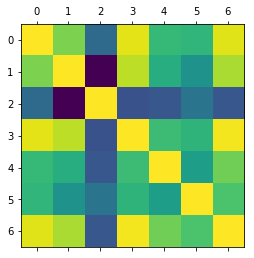

In [385]:
# Correlation between features
columns_to_explore = ['trip_distance', 'travel_time_sec', "fare_by_sec", "fare_amount", 
                      "tip_amount", "tolls_amount", "total_amount"]
corr_matrix = df[columns_to_explore].corr()

display(corr_matrix)
plt.matshow(corr_matrix)
plt.show()

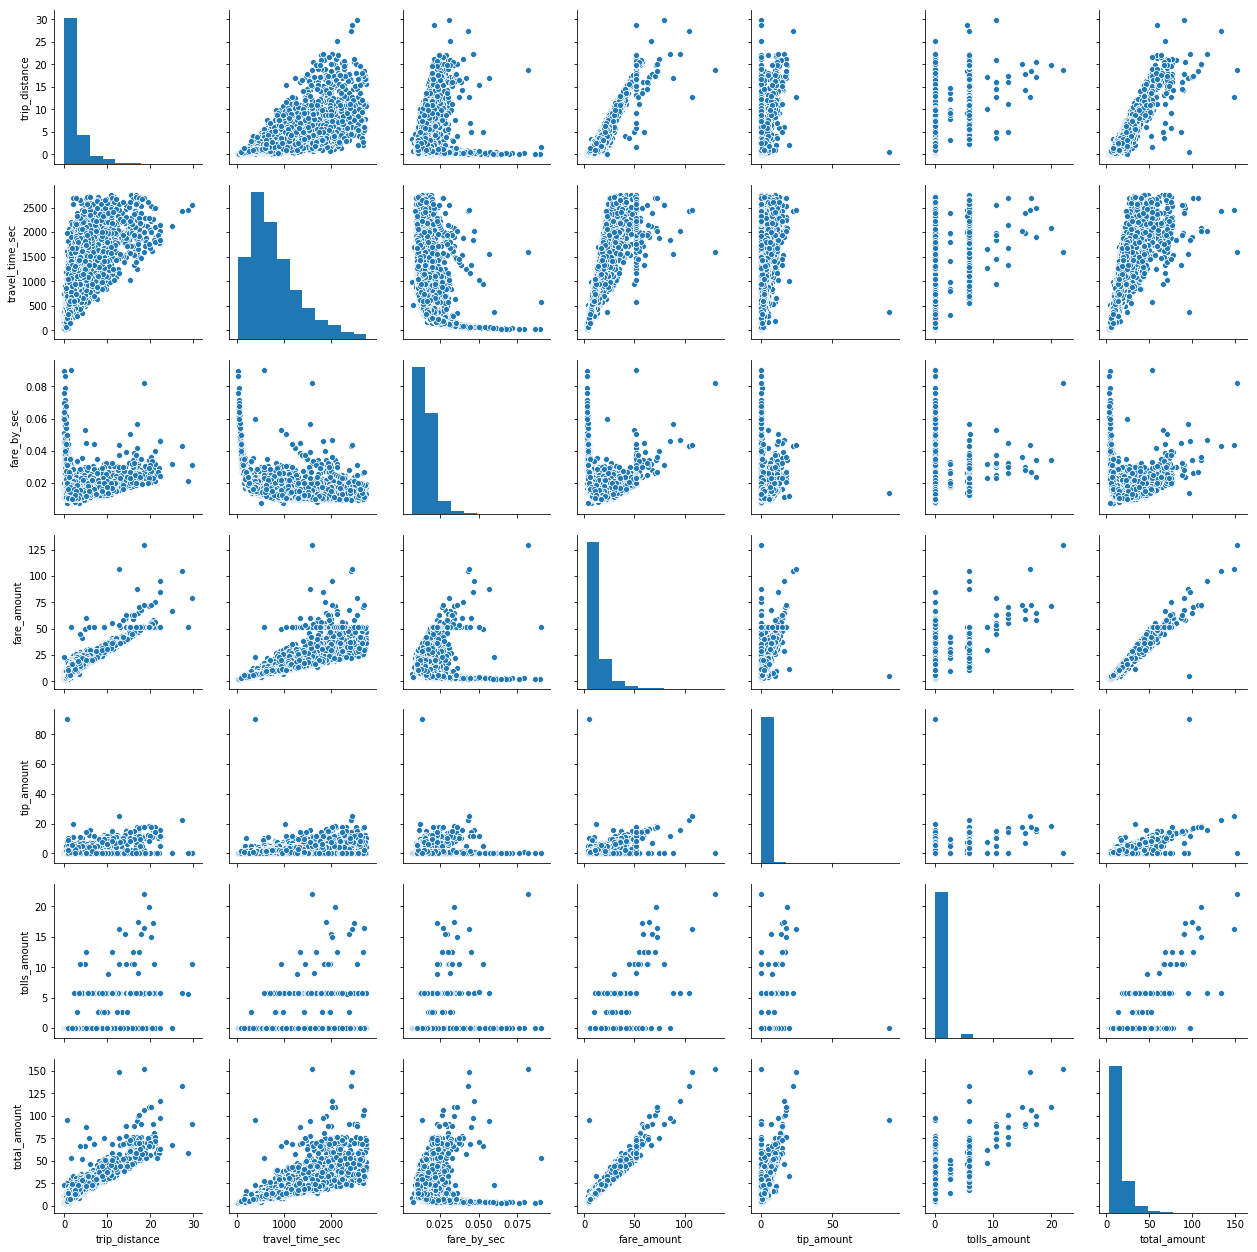

In [386]:
# Distribution of and interaction between numerical features
# Further deep dive in charts below
df_sample = df.sample(10000)
sns.pairplot(df_sample[columns_to_explore]);

### Distributions in Detail

Median Travel Time: 10.983333333333333 Minutes


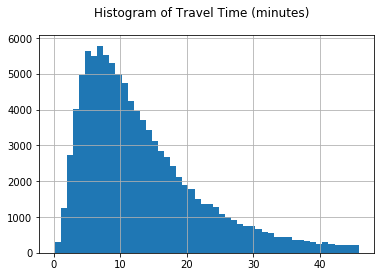

In [387]:
#Distribution A: Travel Time
df_sample = df.sample(100000)
df_sample['travel_time_min'] = df_sample['travel_time_sec']/60
df_sample['travel_time_min'].hist(bins=50)
pl.suptitle("Histogram of Travel Time (minutes)")

# print(df_sample['travel_time_sec'].describe())
print("Median Travel Time: %s Minutes" % (df_sample['travel_time_sec'].median()/60))

Median Total Amount: $9.5 USD


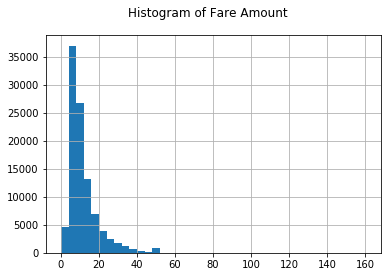

In [389]:
#Distribution B: Fare Amount
df_sample['fare_amount'].hist(bins=40)
pl.suptitle("Histogram of Fare Amount")

# print(df_sample['travel_time_sec'].describe())
print("Median Fare Amount: $%s USD" % (df_sample['fare_amount'].median()))

Median Fare by Second: $0.014925373134328358 USD


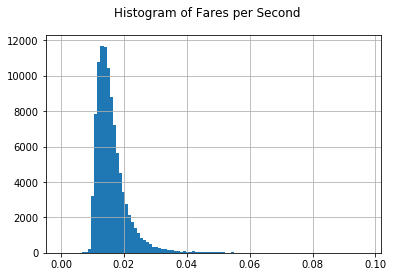

In [393]:
#Distribution C: Income by Time
df_sample['fare_by_sec'].hist(bins=100)
pl.suptitle("Histogram of Fares per Second")
print("Median Fare by Second: $%s USD" % (df_sample['fare_by_sec'].median()))

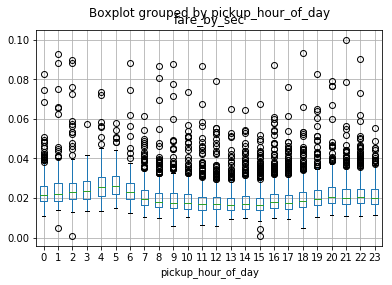

In [26]:
#Distribution C in Detail: fare_by_sec of each hour 
ax = df_sample.boxplot(column='fare_by_sec', by = 'pickup_hour_of_day')


## Conclusions in Detail 

### Strategy I - Speed
One way for yellow taxi drivers to maximize their hourly income is by **driving as fast as traffic and speed limits allow**. 

Following factors affect the average speed over a trip:
* Hour of day and day of week  
    * Between 8 AM to 6 PM on weekdays slower traffic brings average fare per second below .15 cents
    * After Midnight to 6 AM on weekdays drivers see fare per second climb above .19 cents
* Driving skill and style of driver

#### Challenge Strategy I: 
While at night fare per second in the highest the number of trips are lower. This dataset contains the information about the actual trips (demand = supply). 
* Demand - We do not know how many people would have taken a taxi, if they would have seen one at night 
* Supply - We do not know how many taxis are competing for passangers at night, resulting in lower utilization rates
* Utilization Rate of taxis by hour of day, day of week and zone

In [372]:
df_sample = df.sample(100000)
dfP = df_sample[(df_sample.fare_by_sec >0)&(df_sample.fare_by_sec <0.1)]
dfP = dfP.groupby(features).mean().reset_index()

# Create a trace
timeslot_wd = dfP[features[0]].isin(range(8,19))
highprice = dfP.fare_by_sec > 0.019

weekday = dfP[features[1]].isin(range(0,5))
dfP1 = dfP[timeslot_wd & weekday]
trace = go.Scatter(
    x = dfP1[features[0]] + dfP1[features[1]]*24,
    y = dfP1["fare_by_sec"],
    mode='markers',
    name = 'Low Fare'
)
data = [trace]
dfP2 = dfP[~(timeslot_wd & weekday)]
trace = go.Scatter(
    x = dfP2[features[0]] + dfP2[features[1]]*24,
    y = dfP2["fare_by_sec"],
    mode='markers',
    name = 'Medium Fare'

)
data.append(trace)
dfP3 = dfP[(highprice)]
trace = go.Scatter(
    x = dfP3[features[0]] + dfP3[features[1]]*24,
    y = dfP3["fare_by_sec"],
    mode='markers',
    name = 'High Fare'
)
data.append(trace)

layout = go.Layout(
    title=go.layout.Title(
        text='Fares per second over the week',
        xref='paper',
        x=0
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='Fares per second',
        )
    ),
    xaxis=dict(
        title=go.layout.xaxis.Title(
            text='hour of week',
        ),
        tickmode='linear',
        ticks='outside',
        tick0=0,
        dtick=24,
        ticklen=8,
        tickwidth=4,
        tickcolor='#000'
    )
)
# Plot and embed in ipython notebook!
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='basic-scatter')


### Trip Time
While at night fewer trips are driven, they result in higher fares.

Between 2 AM to 5 AM the fewest trips are taken

Text(0.5, 0.98, 'Histogram of Trips per hour')

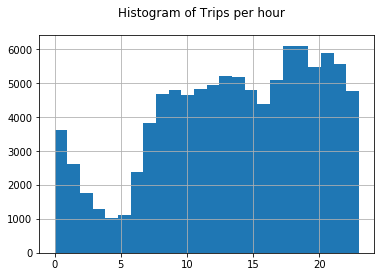

In [381]:
# Distribution of trips started by hour
ax = df_sample["pickup_hour_of_day"].hist(bins=24)
pl.suptitle("Histogram of Trips per hour")

### Strategy II - Service Zones /Rate 
Another way to maximize hourly income is to **perform trips from and in some cases to the airport** as they are performed using a more expensive rate code. To maximize airport trips the taxi driver could target hotels or other parts of town that have more passangers interested in getting to the aiport as every trip to the airport allows for another trip from the airport.

#### Challenge Strategy II: 
We do not know how long taxis have to wait in line for passangers at the airport, potentially resulting in lower hourly income.

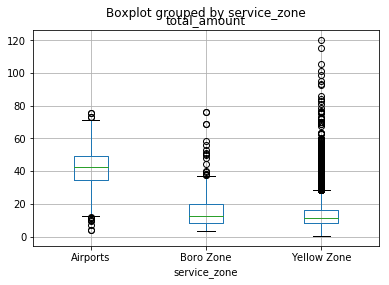

In [374]:
# Distribution by service zone
df.service_zone.unique()
df_sample_ = df.sample(10000)
df_sample_ = df_sample_[(df_sample_.total_amount > 0)]
ax = df_sample_.boxplot(column='total_amount', by = 'service_zone')


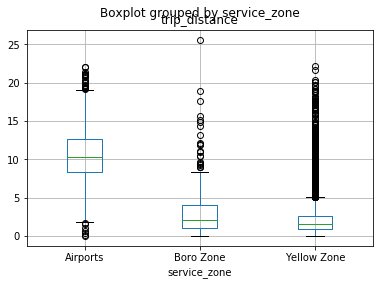

In [392]:
ax = df_sample_.boxplot(column='trip_distance', by = 'service_zone')

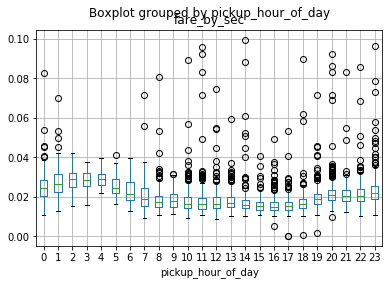

In [377]:
#When is the best time to pickup customers from airport
df_sample_ap = df[df['service_zone'] == "Airports"].sample(10000)
df_sample_ap = df_sample_ap[(df_sample_ap.fare_by_sec < 0.1) &(df_sample_ap.fare_by_sec > 0)]

ax = df_sample_ap.boxplot(column='fare_by_sec', by = 'pickup_hour_of_day')


Text(0.5, 0.98, 'Histogram of Trips per hour from Airports')

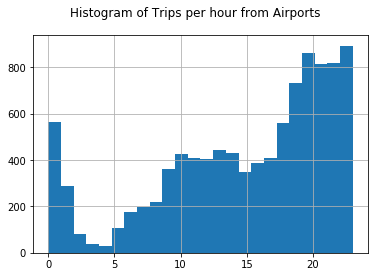

In [380]:
df_sample_ap["pickup_hour_of_day"].hist(bins=24)
pl.suptitle("Histogram of Trips per hour from Airports")